# Vision Transformers (ViT) 

Binary Image Classification of chest X-ray images. The dataset consists of a binary labeled Chest Ray Images (https://pubmed.ncbi.nlm.nih.gov/29474911/). This data consists of two pneumonia diseases, bacterial and viral, both labeled PNEUMONIA, augmented with images labeled as NORMAL.




## Environment Setup

In [1]:
!pip install tensorflow_addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


import pandas as pd
import json
import zipfile
import os
import seaborn as sns
import random
import shutil
import time

from PIL import Image
from matplotlib import pyplot as plt 

from keras.models import Sequential, Model

from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2, ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

!pip install wandb
import wandb
from wandb.keras import WandbCallback

!mkdir output
!mkdir output/tmp-augmented-images/

random.seed(123)

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 139 kB 48.9 MB/s 
     |████████████████████████████████| 180 kB 48.6 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=5ef3978d3428c50dc86e4ba17417a54a1080e09f83ec7a2c95910e33fc3815e9
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=0d16d130643ea6106e46b65fdc69cdb88625ac7eddee36ef4575047e4fc7d0d6
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


## Dataset

In [2]:
# You need to insert your own API key below to run the code

kaggle = {
    "username": "<your-kaggle-username>",
    "api_key": "<your-kaggle-api-key>",
    "on_kernel": False,
    "dataset": {
        "sample": "-",
        "full": "paultimothymooney/chest-xray-pneumonia"
        }
}

if kaggle["on_kernel"]:
  path_prefix = '/kaggle/working/'
else:
  path_prefix = '/content/'

# Download dataset
def download_dataset(which_dataset):
  data = {"username": kaggle["username"],"key": kaggle["api_key"]}
  with open('kaggle.json', 'w') as json_file:
      json.dump(data, json_file)

  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  kaggle_dataset = kaggle["dataset"][which_dataset]
  !kaggle datasets download -d $kaggle_dataset
  
  # Paths neeeds to be changed manually because of different directory structures, check with !ls
  if not os.path.isdir('dataset'):
    print("Unzipping... ")
    zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
    zip_ref.extractall('dataset')
    zip_ref.close()
    !rm -rf /content/dataset/chest_xray/chest_xray
    !rm -rf /content/dataset/chest_xray/__MACOSX
    !rm -rf /content/chest-xray-pneumonia.zip
  

  #!ls Data


download_dataset("full")

data_files = os.listdir("dataset/chest_xray")
print(data_files)

 99% 2.28G/2.29G [00:29<00:00, 98.5MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.6MB/s]
Unzipping... 
['train', 'test', 'val']


In [3]:
def resample_data(move_from, move_to, cl, images_to_move=100):
  path = path_prefix + 'dataset/chest_xray/'

  classes = os.listdir(path + move_from)

  cl += '/'
  curr_path = path + move_from + cl
  for _, _, files in os.walk(curr_path):
    random.shuffle(files)
    files_to_move = files[:images_to_move]
    for fn in files_to_move:
      shutil.move(curr_path + fn, path + move_to + cl + fn)
      #print('Moved ' + curr_path + fn)
        
  print('Resampled Images')

move_from, move_to = 'train/', 'val/'
#resample_data(move_from, move_to, 'PNEUMONIA', 2534)



# Training images
print('Number of NORMAL training images:')
!ls /content/dataset/chest_xray/train/NORMAL/ | wc -l
print('Number of PNEUMONIA training images:')
!ls /content/dataset/chest_xray/train/PNEUMONIA/ | wc -l
print()


# Test images 
#resample_data('test/', 'val/', 'PNEUMONIA', 2690)
print('Number of NORMAL test images:')
!ls /content/dataset/chest_xray/test/NORMAL/ | wc -l
print('Number of PNEUMONIA test images:')
!ls /content/dataset/chest_xray/test/PNEUMONIA/ | wc -l

Number of NORMAL training images:
1341
Number of PNEUMONIA training images:
3875

Number of NORMAL test images:
234
Number of PNEUMONIA test images:
390


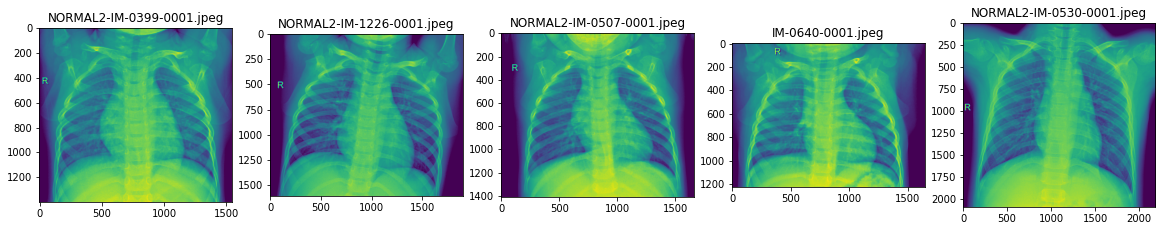

In [4]:
def viewImagesFromDir(path, num=5):
  #Display num random images from dataset. Rerun cell for new random images. The images are only single-channel

  img_paths_visualise = sorted(
        os.path.join(path, fname)
        for fname in os.listdir(path)
        if fname.endswith(".jpeg")
  )

  random.shuffle(img_paths_visualise)

  fig, ax = plt.subplots(1, num, figsize=(20, 10))

  for i in range(num):
    ax[i].imshow(Image.open(img_paths_visualise[i]))
    index = img_paths_visualise[i].rfind('/') + 1
    ax[i].title.set_text(img_paths_visualise[i][index:])

  fig.canvas.draw()
  time.sleep(1)

viewImagesFromDir('/content/dataset/chest_xray/train/NORMAL/', num=5)

# Prepare the data

## Configure the hyperparameters

In [5]:
CLASSES = os.listdir('/content/dataset/chest_xray/train') 
TRAINING_DATA_SET_PATH = '/content/dataset/chest_xray/train'
TEST_DATA_SET_PATH = '/content/dataset/chest_xray/test'

params = dict(
    seed = 123,
    image_dim = (288,288),
    weight_decay = 1e-4,
    epochs = 30,
    batch_size = 16,
    patch_size = 18,
    pool_size = (2,2),
    optimizer = 'Adam',
    l_rate = 0.001,
    val_split = .15,
    use_transfer_learning = False,
    use_data_aug = False,

    l2_reg = .0,
    projection_dim = 16,
    num_heads = 4,
    
    # Size of the transformer layers
    transformer_layers = 4,
    num_classes = len(CLASSES),
    mlp_head_units = [1024,512]
    
    )

new_params = dict(
    num_patches = (params['image_dim'][0] // params['patch_size']) ** 2,
    transformer_units = [
    params['projection_dim'] * 2,
    params['projection_dim']],
    input_shape = (params['image_dim'][0], params['image_dim'][1], 3),

)
params.update(new_params)


if params['use_data_aug']:
  data_aug_params = dict(
      da_rotation = 20,
      da_w_shift = 0.1,
      da_h_shift = 0.1,
      da_shear = 0.05,
      da_zoom = 0.05,
      da_h_flip = False,
      da_v_flip = False,
  )

  params.update(data_aug_params)


# Ability to switch amount of channel to utilise pre-trained models with specific input shapes
if params['use_transfer_learning']:
  INPUT_SHAPE = (params['image_dim'][0], params['image_dim'][1], 3)
  COLOUR_MODE = 'rgb'
else:
  INPUT_SHAPE = (params['image_dim'][0], params['image_dim'][1], 3)
  COLOUR_MODE = 'rgb'

if params['use_data_aug']:
  datagen = ImageDataGenerator(validation_split=params['val_split'], rescale=1./255,  
                               rotation_range=params['da_rotation'],
                               width_shift_range=params['da_w_shift'],
                               height_shift_range=params['da_h_shift'],
                               shear_range=params['da_shear'],
                               zoom_range=params['da_zoom'],
                               horizontal_flip=params['da_h_flip'],
                               vertical_flip=params['da_v_flip'],
                               fill_mode="constant",
                               cval=0
                               )
else:
  datagen = ImageDataGenerator(validation_split=params['val_split'])

# Read all training and validation data into variables from directory. 
# Due to faulty quality of the given validation-set images, all images are taken from the training folder
train_generator = datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    subset='training',
                                                    shuffle=True)

val_datagen = ImageDataGenerator(validation_split=0.15, rescale=1./255)
valid_generator = datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    subset='validation',
                                                    shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    shuffle=False)


Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Custom Layers

The following cells uses inspiration from Khalid Salamas and the  [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) paper from Google Research on Vision Transformers.

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    
# Linearly transform patches by projecting it into a
# vector of size `projection_dim` and also adds a learnable position
# embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Image size: 288 X 288
Patch size: 18 X 18
Patches per image: 256
Elements per patch: 972


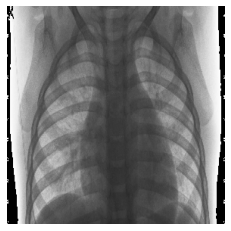

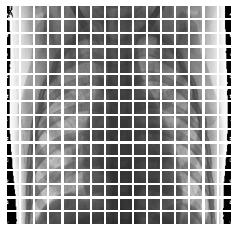

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image, label = iter(next(train_generator))
image = image[0]*255.
#image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(params['image_dim'][0], params['image_dim'][0])
)
patches = Patches(params['patch_size'])(resized_image)
print(f"Image size: {params['image_dim'][0]} X {params['image_dim'][0]}")
print(f"Patch size: {params['patch_size']} X {params['patch_size']}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (params['patch_size'], params['patch_size'], 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Generate ViT model

In [8]:
def create_vit_classifier():
    inputs = layers.Input(shape=params['input_shape'])
    # Create patches.
    patches = Patches(params['patch_size'])(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(params['num_patches'], params['projection_dim'])(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(params['transformer_layers']):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=params['num_heads'], key_dim=params['projection_dim'], dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=params['transformer_units'], dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=params['mlp_head_units'], dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(len(CLASSES))(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Train Model

In [9]:
from keras import backend as K

# For experiment tracking
USE_WANDB = False

if USE_WANDB:
  wandb.init(tags=["ViT", "Binary"], project='dd2424', entity='teambumblebee', sync_tensorboard=True, config=params, save_code=True)
  print(params)
  wandb_callback = WandbCallback(monitor='val_f1_m', 
                                 save_model=True,
                                 save_weights_only=False, mode='max',
                                 log_weights=True,
                                 data_type="image", verbose=1, 
                                 labels=CLASSES, 
                                 generator=valid_generator,
                                 predictions=50,
                                 log_evaluation=True,
                                 log_batch_frequency=1) 

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=params['l_rate'], weight_decay=params['weight_decay']
    )
    
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="binary_accuracy"), f1_m, recall_m, precision_m
        ],
    )

    
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        "/content/output/model_best.h5",
        monitor="val_f1_m",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
        mode="max"
    )

    callbacks_list = [checkpoint_callback, tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_binary_accuracy")]

    if USE_WANDB:
      callbacks_list.append(wandb_callback)


    history = model.fit(
        train_generator,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=valid_generator,
        callbacks=callbacks_list) 

    return history, model

model = create_vit_classifier()
history, model = run_experiment(model)

Epoch 1/30
278/278 [==============================] - 78s 248ms/step - loss: 0.6476 - binary_accuracy: 0.7629 - f1_m: 0.7479 - recall_m: 0.7100 - precision_m: 0.7983 - val_loss: 0.5282 - val_binary_accuracy: 0.8095 - val_f1_m: 0.7933 - val_recall_m: 0.7666 - val_precision_m: 0.8257

Epoch 00001: val_f1_m improved from -inf to 0.79333, saving model to /content/output/model_best.h5
Epoch 2/30
278/278 [==============================] - 67s 241ms/step - loss: 0.3202 - binary_accuracy: 0.8593 - f1_m: 0.8516 - recall_m: 0.8127 - precision_m: 0.8980 - val_loss: 0.3719 - val_binary_accuracy: 0.8600 - val_f1_m: 0.8475 - val_recall_m: 0.8189 - val_precision_m: 0.8824

Epoch 00002: val_f1_m improved from 0.79333 to 0.84753, saving model to /content/output/model_best.h5
Epoch 3/30
278/278 [==============================] - 67s 241ms/step - loss: 0.2250 - binary_accuracy: 0.9026 - f1_m: 0.8992 - recall_m: 0.8746 - precision_m: 0.9272 - val_loss: 0.2690 - val_binary_accuracy: 0.8862 - val_f1_m: 0.88